In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #绘图模块，基于matplotlib的可视化python包,不能完全替代matplotlib,只是对matplotlib进行升级
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline

#pip install seaborn

## 1.加载数据

In [3]:
#parse_dates:将指定的列加载成日期的格式
offline = pd.read_csv('ccf_offline_stage1_train.csv',parse_dates=['Date_received','Date'])
offline.info()  #175+万条数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   User_id        int64         
 1   Merchant_id    int64         
 2   Coupon_id      float64       
 3   Discount_rate  object        
 4   Distance       float64       
 5   Date_received  datetime64[ns]
 6   Date           datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 93.7+ MB


In [4]:
offline.head(10)   #NaT:时间日期格式的空值

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT
5,1439408,2632,NaN,NaN,0.0,NaT,2016-05-16
6,1439408,2632,8591.0,20:1,0.0,2016-05-16,2016-06-13
7,1832624,3381,7610.0,200:20,0.0,2016-04-29,NaT
8,2029232,3381,11951.0,200:20,1.0,2016-01-29,NaT
9,2029232,450,1532.0,30:5,0.0,2016-05-30,NaT


## 2.数据的规整

In [5]:
#判断每一列当中有多少个空值
offline.isnull().sum()
#优惠券id，折扣率，领券日期，三者可能存在同时==null的情况

User_id               0
Merchant_id           0
Coupon_id        701602
Discount_rate    701602
Distance         106003
Date_received    701602
Date             977900
dtype: int64

### 2.1把“Discount_rate”列中的满减政策转换成折扣率

In [6]:
offline['Discount_rate'] = offline['Discount_rate'].fillna('null')
offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,null,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:1,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:1,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:1,0.0,2016-06-13,NaT


In [7]:
def discount_rate_opt(s): #s代表每一个元素
    if ':' in s:
        split = s.split(':')
        discount_rate = (int(split[0]) - int(split[1]))/int(split[0])
        return round(discount_rate,2)  #折扣率保留两位小数
    elif s == 'null':
        return np.NaN
    else:
        return float(s)

In [8]:
offline['Discount_rate']  = offline['Discount_rate'].map(discount_rate_opt)
offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,0.87,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,0.95,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,0.95,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,0.95,0.0,2016-06-13,NaT


### 2.2 Coupon_id字段：null代表无优惠券，此时Discount_rate与Date_received字段无意义。
检查Coupon_id和Discount_rate与Date_received判断空值和非空值是否一一对应。

In [9]:
#np.all():判断一个课迭代数据中是否都为True，如果是返回True，否则返回False
np.all([True,False,True])

False

In [10]:
nan1 = offline['Coupon_id'].isnull()  #判断优惠券是否为空
nan2 = offline['Date_received'].isnull()   #判断领券日期是否为空
np.all(nan1 == nan2)  #如果结果=true，说明之前的猜测：Coupon_id与Date_received空值与非空值是一一对应的关系

True

In [11]:
nan3 = offline['Discount_rate'].isnull()
np.all(nan1 == nan3)#如果结果=true，说明之前的猜测：Coupon_id与Discount_rate空值与非空值是一一对应的关系

True

### 2.3
如果Date=null & Coupon_id!=null,有券未消费（cpon_no_consume）
如果Date=null & Coupon_id =null,无券未消费（no_cpon_no_consume）
如果Date！=null & Coupon_id=null,无券消费（no_cpon_consume）
如果Date！=null & Coupon_id!=null,有券消费（cpon_consume）

In [12]:
cpon_no_consume = offline[(offline['Date'].isnull() & offline['Coupon_id'].notnull())]
no_cpon_no_consume = offline[(offline['Date'].isnull() & offline['Coupon_id'].isnull())]
no_cpon_consume = offline[(offline['Date'].notnull() & offline['Coupon_id'].isnull())]
cpon_consume = offline[(offline['Date'].notnull() & offline['Coupon_id'].notnull())]

In [13]:
print('有券未消费:{}'.format(len(cpon_no_consume)))
print('无券未消费:{}'.format(len(no_cpon_no_consume)))  #无意义，不需分析
print('无券消费:{}'.format(len(no_cpon_consume)))
print('有券消费:{}'.format(len(cpon_consume)))
#用优惠券消费的用7万，相比其他用户来说，占比较少

有券未消费:977900
无券未消费:0
无券消费:701602
有券消费:75382


## 3.数据分析


In [14]:
#绘制饼图占比
consume_status_dict = {'cpon_no_consume':len(cpon_no_consume),'no_cpon_consume':len(no_cpon_consume),'cpon_consume':len(cpon_consume)}
consume_status = pd.Series(consume_status_dict)
consume_status

cpon_no_consume    977900
no_cpon_consume    701602
cpon_consume        75382
dtype: int64

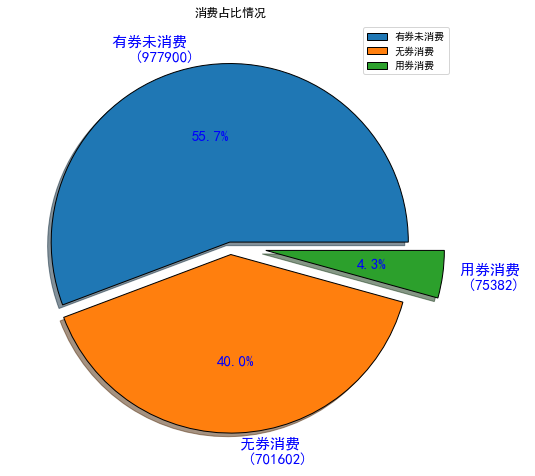

In [15]:
#消费方式构成的饼图（figure：看作是一张画布，axes：代表画布内的多个坐标系）
fig,ax=plt.subplots(1,1,figsize=(8,10))
consume_status.plot.pie(ax = ax,
                       autopct='%1.1f%%',
                       shadow=True,
                        explode=[0.02,0.05,0.2],
                        textprops={'fontsize':15,'color':'blue'},
                        wedgeprops={'linewidth':1,'edgecolor':'black'},
                        labels=['有券未消费 \n ({})'.format(len(cpon_no_consume)),
                                '无券消费 \n ({})'.format(len(no_cpon_consume)),
                               '用券消费 \n ({})'.format(len(cpon_consume))
                               ]
                       )
ax.set_ylabel('')  #去除ylable
ax.set_title('消费占比情况')
plt.legend(labels=['有券未消费','无券消费','用券消费'])
#有券未消费占比55.7%最大，说明大多数人拿完券之后，尚未使用
#无圈消费用户占比40%，说明很多人没有使用优惠券，可能优惠券的吸引力不大，客户没在意；可能，新用户比较多。
#用券消费用户占比较小4.3%,说明我们的优惠券使用率不高。可以考虑是不是加大优惠券力度.....

## 3.1在有券消费人群中，分析距离和优惠折扣

In [16]:
#各商家对应的顾客到店平均距离
Merchant_distance = cpon_consume.groupby('Merchant_id')['Distance'].mean()
Merchant_distance[Merchant_distance==0]
#有4076个商家，有1431个商家的用券消费用户平均范围在500米以内

Merchant_id
3       0.0
4       0.0
13      0.0
14      0.0
18      0.0
       ... 
8806    0.0
8824    0.0
8828    0.0
8849    0.0
8856    0.0
Name: Distance, Length: 1431, dtype: float64

Merchant_id
3       0.670
4       0.830
5       0.750
13      0.900
14      0.830
        ...  
8844    0.895
8849    0.950
8850    0.950
8852    0.950
8856    0.925
Name: Discount_rate, Length: 4076, dtype: float64

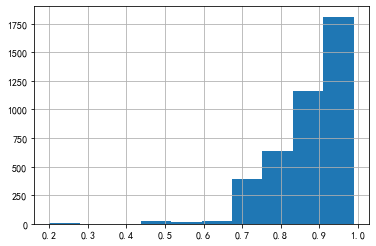

In [17]:
#各商家对应的顾客到店消费平均折扣力度
Merchant_discount_rate = cpon_consume.groupby('Merchant_id')['Discount_rate'].mean()
Merchant_discount_rate.sort_values()
Merchant_discount_rate.hist()
Merchant_discount_rate.mean()  #所有商家平均折扣的平均值：0.88
Merchant_discount_rate

## 3.2持券到店消费人数最多的商家

In [18]:
#对商家进行分组，取出用户id，对用户id进行去重统计数量、
popular_merchant = cpon_consume.groupby('Merchant_id')['User_id'].apply(lambda x:len(x.unique())).sort_values(ascending=False)
#找出持券消费人数>500的商家id
popular_merchant500 = popular_merchant[popular_merchant>500]
popular_merchant500.name = 'customer_count'  #指定列名为消费者数量（持券消费者）
print(len(popular_merchant500))
print(popular_merchant500)
#共有16家店铺，持券消费人数在500人以上
#持券消费人数最多商家是5341，持券消费人数在2800
#排名最后的商家，持券消费人数未559人
#这批商家对优惠券的使用方法得当，消费者喜欢用优惠券进行消费，可以适当借鉴这批商家的推广力度

16
Merchant_id
5341    2800
760     2627
3381    2248
6485    2029
2099    1401
2934    1310
450     1094
3532     968
7555     925
1520     870
6901     855
3621     851
4142     832
1379     587
1469     584
1433     559
Name: customer_count, dtype: int64


## 3.3持券消费人数在500人以上的商家，连接顾客到店平均距离和平均折扣力度

In [19]:
merchant_pop_dis = pd.merge(left=popular_merchant500,right=Merchant_distance,on='Merchant_id',how='inner')
merchant_pop_dis_rate = pd.merge(left=merchant_pop_dis,right=Merchant_discount_rate,on='Merchant_id',how='inner')
merchant_pop_dis_rate

,customer_count,Distance,Discount_rate
Merchant_id,,,
5341,2800,0.168598,0.826036
760,2627,0.349866,0.799873
3381,2248,1.652429,0.744150
6485,2029,0.368567,0.770439
2099,1401,0.968072,0.900000
2934,1310,1.114833,0.830000
450,1094,0.892164,0.819274
3532,968,0.272498,0.852289
7555,925,1.329977,0.828381


## 3.4计算到店消费人数与平均距离和折扣力度的相关系数

In [20]:
#corr(correlation:相关系数)，用来计算df数据中列与列的相关性（皮尔逊相关系数），取值范围[-1,1]之间
#1：完全正相关，-1：完全负相关
#绝对值越大：相关性越大，反之成立
#正相关：随着变量的增大，而增大，反之同理
#负相关：随着变量的增大，而减小，反之同理
merchant_pop_dis_rate.corr()
#持券消费人数，与距离和折扣率都呈现出负相关，属于生活中的正常现象

,customer_count,Distance,Discount_rate
customer_count,1.000000,-0.306180,-0.204102
Distance,-0.306180,1.000000,-0.397376
Discount_rate,-0.204102,-0.397376,1.000000


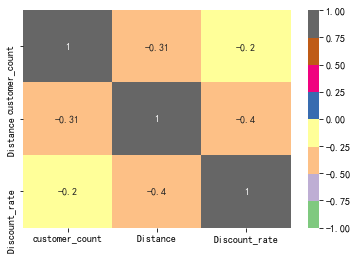

In [21]:
#用热力图展示相关系数(data:相关系数，annot：显示相关系数值，cmap：颜色范围，vmax：最大值，vmin：最小值)
sns.heatmap(data=merchant_pop_dis_rate.corr(),annot=True,cmap='Accent',vmax=1,vmin=-1)

In [22]:
#由图可知：
#1.到店消费人数的多少与顾客到店铺的距离之间呈现负相关，相关系数0.31，在0.3~0.5之间，为低度相关
#2.到店消费人数的多少与优惠打折力度呈现负相关，相关系数0.2，在0~0.3之间，为相关程度极弱
#综上所述，这些店家之所以火爆，应该是物美价廉导致，与距离和优惠力度相关性不大

## 4.1分析每天中优惠券的总体发放量与使用量情况

In [23]:
#业务分析：日期（优惠券的发放日期Date_received，使用日期date）用作图表的x轴
#需要统计每天优惠券发放数量和使用数量

In [24]:
offline['Date'].notnull().sum()  #77.7万消费数据

776984

In [25]:
offline['Date_received'].notnull().sum()  #已经发送出105万优惠券

1053282

In [26]:
#取出存在消费日期的记录，进行升序，再去重
date_sort = offline[offline['Date'].notnull()]['Date'].sort_values().unique()
date_sort[:5]

array(['2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-04T00:00:00.000000000',
       '2016-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [27]:
#取出存在领券日期的记录，进行升序，再去重
date_receive_sort = offline[offline['Date_received'].notnull()]['Date_received'].sort_values().unique()
date_receive_sort[:5]

array(['2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-04T00:00:00.000000000',
       '2016-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [28]:
#每天优惠券的使用量（即持券消费人群）
consume_num_everday =  cpon_consume[['User_id','Date_received']]
consume_num_everday = consume_num_everday.groupby('Date_received').count()
consume_num_everday = consume_num_everday.rename(columns={'User_id':'count'})
consume_num_everday

,count
Date_received,
2016-01-01,74
2016-01-02,67
2016-01-03,74
2016-01-04,98
2016-01-05,107
...,...
2016-06-11,351
2016-06-12,330
2016-06-13,439


In [29]:
#每天发放的优惠券数量(取出所有领券日期！=null的数据，在进行按天分组，计数就可以)
coupon_sendout_everyday = offline[offline['Date_received'].notnull()][['Date_received','User_id']]
coupon_sendout_everyday = coupon_sendout_everyday.groupby('Date_received').count()
coupon_sendout_everyday = coupon_sendout_everyday.rename(columns={'User_id':'count'})
coupon_sendout_everyday

,count
Date_received,
2016-01-01,554
2016-01-02,542
2016-01-03,536
2016-01-04,577
2016-01-05,691
...,...
2016-06-11,5211
2016-06-12,4005
2016-06-13,7861


ValueError: shape mismatch: objects cannot be broadcast to a single shape

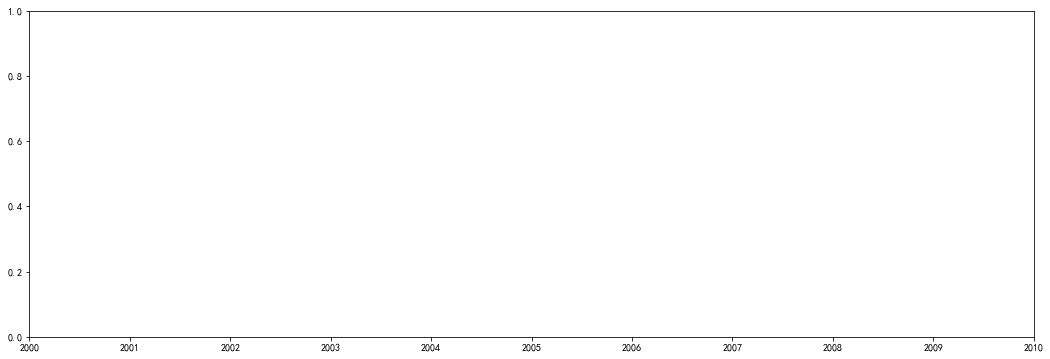

In [34]:
#绘制每天发券量和每天用券量
plt.figure(figsize=(18,6))
# plt.bar(x=date_receive_sort,height=coupon_sendout_everyday['count'],label='每天发券量')
plt.bar(x=date_sort,height=consume_num_everday['count'],label='每天用券量')
plt.yscale('log')  #对y轴进行对数缩放
plt.legend()
#16年2月为例，用券量级别再1000，发券量再10万左右，在100倍左右，优惠券的使用率还是非常低的

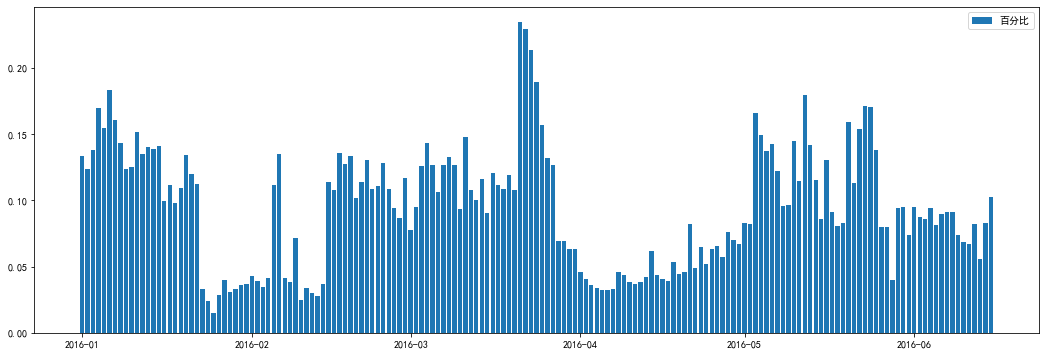

In [31]:
#计算每天的优惠券与发券量占比
plt.figure(figsize=(18,6))
plt.bar(x=date_receive_sort,height=consume_num_everday['count']/coupon_sendout_everyday['count'],
       label='百分比')
plt.legend()

In [32]:
#由图可知，优惠券使用率最高在16年3月底，达到了30%
#使用率最低在16年1月底，最低为3%左右。
#整体来看，优惠券使用率波动较大。